<a href="https://colab.research.google.com/github/ladrianx/proyectos/blob/main/nn_retro_stf_p4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Programa en *R* usando *Keras*

Loading required package: xts



Loading required package: zoo




Attaching package: ‘zoo’




The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




Loading required package: TTR



Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



El lag con mayor valor absoluto es: 3 con un valor de: -0.08012288 


El lag más significativo es: 3 


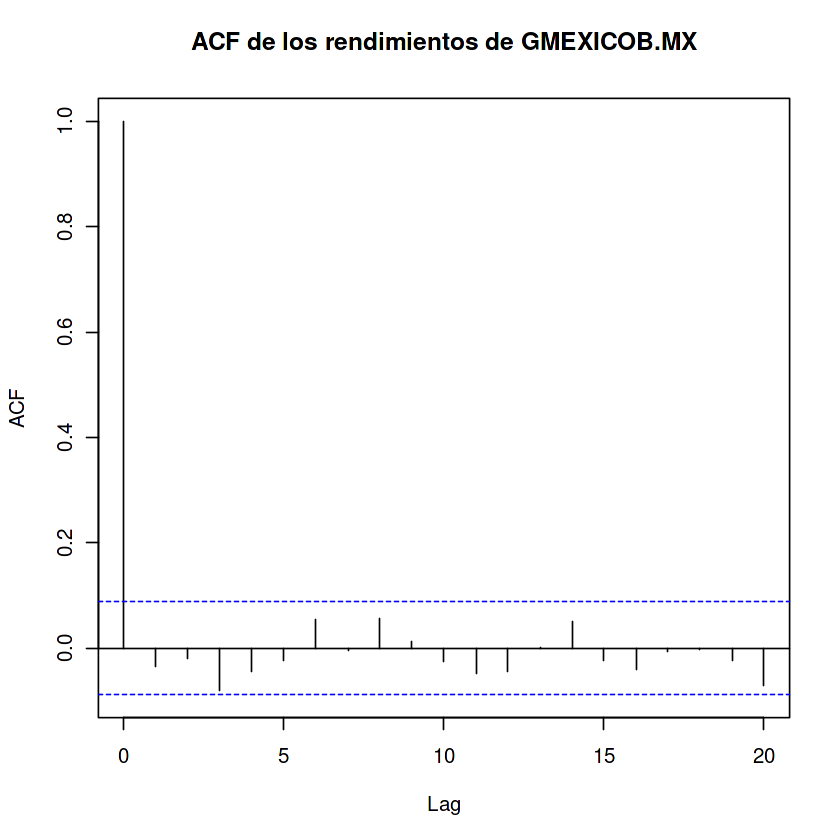

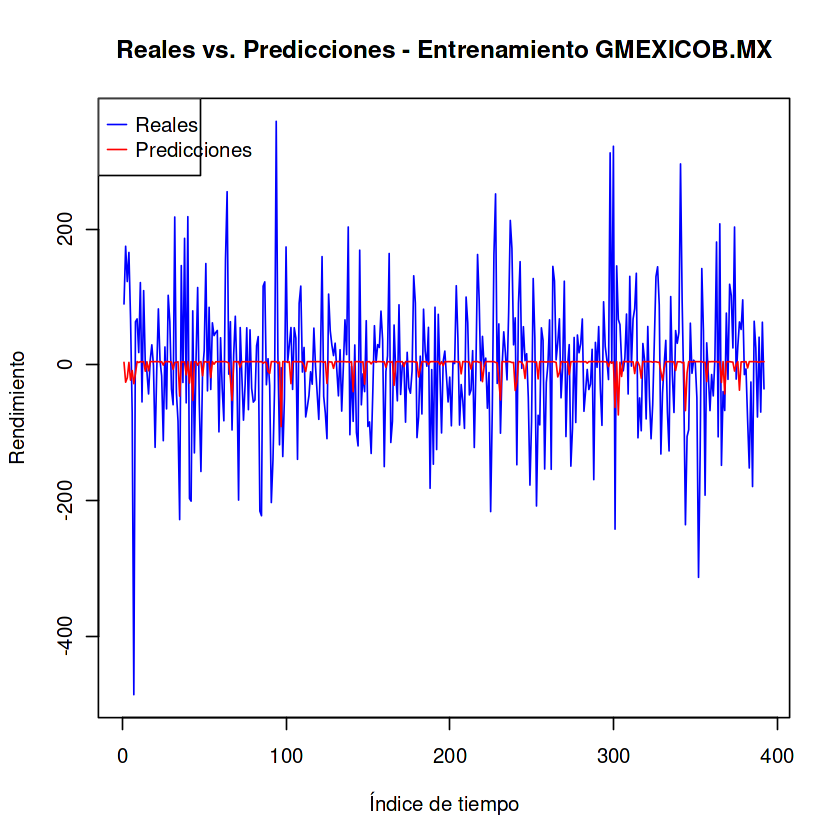

Valor real del último dato: 1.249441 
Predicción del último dato: 0.1552473 
Error absoluto del último dato: 1.094193 
MSE del último dato: 1.197259 


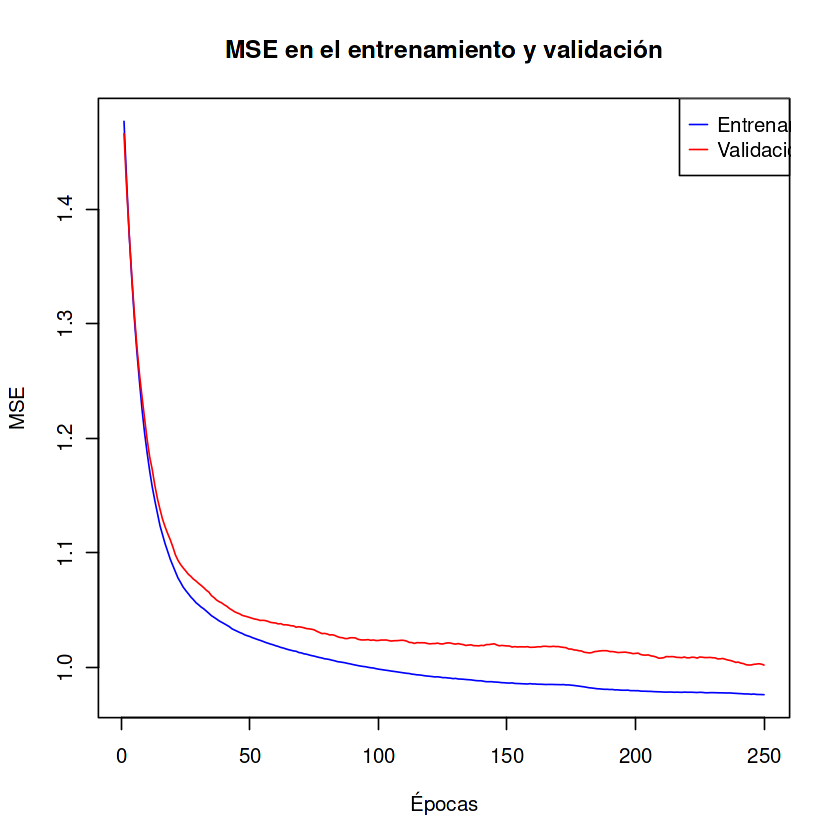

In [ ]:
# Cargar las bibliotecas necesarias
library(keras)
library(quantmod)

# Función para obtener los datos de Yahoo Finance
get_yahoo_data <- function(ticker, start_date, end_date) {
  data <- getSymbols(ticker, src = 'yahoo', from = start_date, to = end_date, auto.assign = FALSE)
  return(data)
}

# Calcular los rendimientos logarítmicos
calculate_returns <- function(data) {
  log_returns <- na.omit(diff(log(Cl(data))))  # Diferencia logarítmica de precios de cierre
  return(log_returns)
}

# Descargar los datos de Yahoo Finance
ticker <- "GMEXICOB.MX"  # Reemplazar por el ticker de tu interés
start_date <- "2023-01-01"
end_date <- "2024-12-22"
data <- get_yahoo_data(ticker, start_date, end_date)

# Calcular los rendimientos logarítmicos
returns <- calculate_returns(data)

# Calcular la ACF y obtener el lag más significativo
acf_result <- acf(returns, lag.max = 20, plot = TRUE, main = paste("ACF de los rendimientos de", ticker))
lags <- acf_result$lag[-1]  # Excluir el lag 0
acf_values <- acf_result$acf[-1]
max_abs_lag <- which.max(abs(acf_values))
lag_significant <- if (length(lags) > 0) lags[max_abs_lag] else 5  # Si no se encuentra lag, poner 5 como predeterminado

cat("El lag con mayor valor absoluto es:", lags[max_abs_lag], "con un valor de:", acf_values[max_abs_lag], "\n")
cat("El lag más significativo es:", lag_significant, "\n")

# Definir la función para generar datos laggeados
generate_lagged_data <- function(returns, lag) {
  n <- length(returns)
  data_matrix <- matrix(NA, nrow = n - lag, ncol = lag + 1)
  for (i in 1:(n - lag)) {
    data_matrix[i, ] <- returns[i:(i + lag)]
  }
  colnames(data_matrix) <- c(paste0("Lag_", 1:lag), "Target")
  return(as.data.frame(data_matrix))
}

# Generar datos laggeados
lag <- as.integer(lag_significant)
lagged_data <- generate_lagged_data(returns, lag)

# Eliminar los valores NA de los datos
lagged_data <- na.omit(lagged_data)

# Separar el último día para evaluación final
final_test <- lagged_data[nrow(lagged_data), , drop = FALSE]
lagged_data <- lagged_data[-nrow(lagged_data), ]

# Dividir los datos restantes en entrenamiento y validación
set.seed(42)
train_ratio <- 0.8
train_size <- floor(train_ratio * nrow(lagged_data))
train_data <- lagged_data[1:train_size, ]
validation_data <- lagged_data[(train_size + 1):nrow(lagged_data), ]

# Normalizar los datos de entrenamiento y validación
normalize <- function(x) {
  if (all(is.na(x))) {
    return(rep(NA, length(x)))  # Si todos son NA, devuelve NA
  }
  if (sd(x, na.rm = TRUE) == 0 || is.na(sd(x, na.rm = TRUE))) {
    return(rep(0, length(x)))  # Evitar divisiones por cero o NA
  }
  return((x - mean(x, na.rm = TRUE)) / sd(x, na.rm = TRUE))
}

train_data_normalized <- as.data.frame(lapply(train_data, normalize))
validation_data_normalized <- as.data.frame(lapply(validation_data, normalize))

# Normalizar los datos de prueba
final_test_normalized <- tryCatch({
  as.data.frame(lapply(final_test, normalize))
}, error = function(e) {
  stop("Error al normalizar final_test: ", e$message)
})

# Verificar si final_test_normalized contiene valores válidos
if (any(is.na(final_test_normalized))) {
  stop("Error: Los datos de prueba normalizados contienen valores NA o inválidos.")
}

# Definir la arquitectura del modelo de red neuronal
input_size <- lag
hidden_size <- lag - 1
output_size <- 1

# Crear el modelo de red neuronal utilizando Keras
model <- keras_model_sequential() %>%
  layer_dense(units = hidden_size, activation = "relu", input_shape = c(input_size)) %>%
  layer_dense(units = output_size)

# Compilar el modelo
model %>% compile(
  loss = "mean_squared_error",  # Aquí usamos MSE en lugar de MAE
  optimizer = optimizer_adam(lr = 0.001),
  metrics = c("mean_squared_error")  # Aseguramos que MSE sea la métrica
)

# Preparar los datos de entrenamiento y validación para Keras
X_train <- as.matrix(train_data_normalized[, -ncol(train_data_normalized)])
Y_train <- as.matrix(train_data_normalized[, ncol(train_data_normalized)])
X_val <- as.matrix(validation_data_normalized[, -ncol(validation_data_normalized)])
Y_val <- as.matrix(validation_data_normalized[, ncol(validation_data_normalized)])

# Entrenar el modelo
history <- model %>% fit(
  X_train,
  Y_train,
  epochs = 250,
  batch_size = 32,
  validation_data = list(X_val, Y_val)
)

# Graficar los rendimientos reales vs. las predicciones durante el entrenamiento
Y_train_pred <- model %>% predict(X_train)
Y_val_pred <- model %>% predict(X_val)

plot(Y_train * 100, type = "l", col = "blue", ylim = c(min(c(Y_train, Y_train_pred)) * 100, max(c(Y_train, Y_train_pred)) * 100), xlab = "Índice de tiempo", ylab = "Rendimiento", main = paste("Reales vs. Predicciones - Entrenamiento", ticker))
lines(Y_train_pred * 100, col = "red")
legend("topleft", legend = c("Reales", "Predicciones"), col = c("blue", "red"), lty = 1)

# Graficar el MSE en el entrenamiento y la validación
plot(history$metrics$mean_squared_error, type = "l", col = "blue", xlab = "Épocas", ylab = "MSE", main = "MSE en el entrenamiento y validación")
lines(history$metrics$val_mean_squared_error, col = "red")
legend("topright", legend = c("Entrenamiento", "Validación"), col = c("blue", "red"), lty = 1)

# Evaluar el modelo con el último dato (final_test) sin normalizar
X_final_test <- as.matrix(final_test_normalized[, -ncol(final_test_normalized)])
Y_final_test <- final_test_normalized[, ncol(final_test_normalized)]
Y_pred_final <- model %>% predict(X_final_test)

# Invertir la normalización de la predicción final
min_val <- min(lagged_data$Target, na.rm = TRUE)
max_val <- max(lagged_data$Target, na.rm = TRUE)
mean_val <- mean(lagged_data$Target, na.rm = TRUE)
sd_val <- sd(lagged_data$Target, na.rm = TRUE)

Y_pred_final_inverted <- (Y_pred_final * sd_val) + mean_val
Y_final_test_inverted <- returns[length(returns)]

# Calcular los errores para los datos invertidos
if (!is.na(Y_pred_final_inverted) && !is.na(Y_final_test_inverted)) {
  mse_final <- (((Y_pred_final_inverted - Y_final_test_inverted) * 100)^2)
  abs_error_final <- abs(Y_pred_final_inverted - Y_final_test_inverted) * 100
  cat("Valor real del último dato:", Y_final_test_inverted * 100, "\n")
  cat("Predicción del último dato:", Y_pred_final_inverted * 100, "\n")
  cat("Error absoluto del último dato:", abs_error_final, "\n")
  cat("MSE del último dato:", mse_final, "\n")
}

# Programa sin gráficas

El lag con mayor valor absoluto es: 3 con un valor de: -0.08012288 


El lag más significativo es: 3 


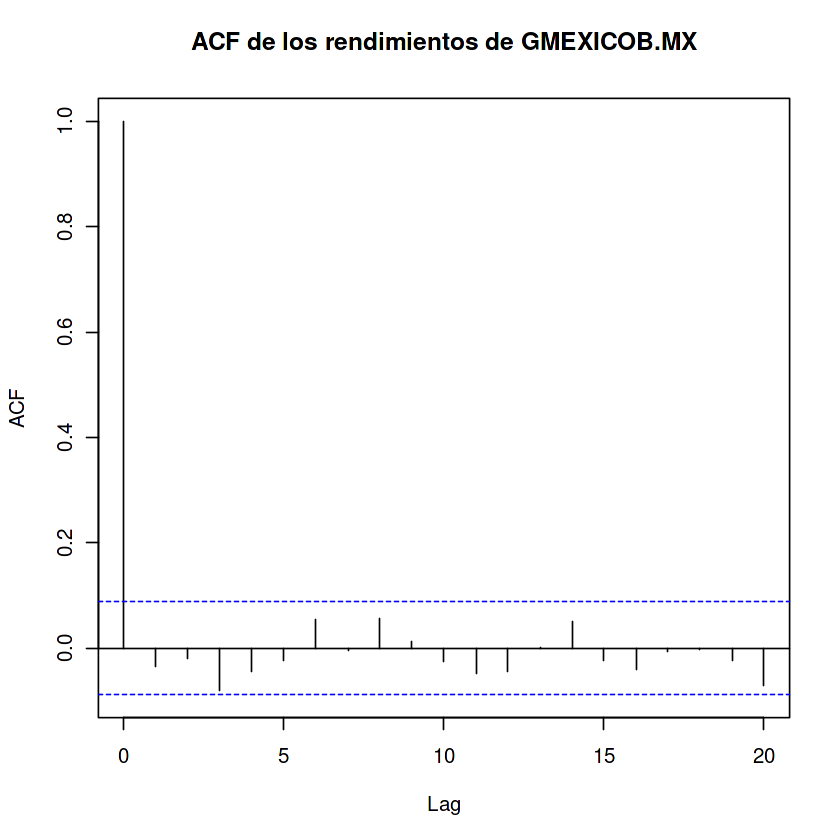

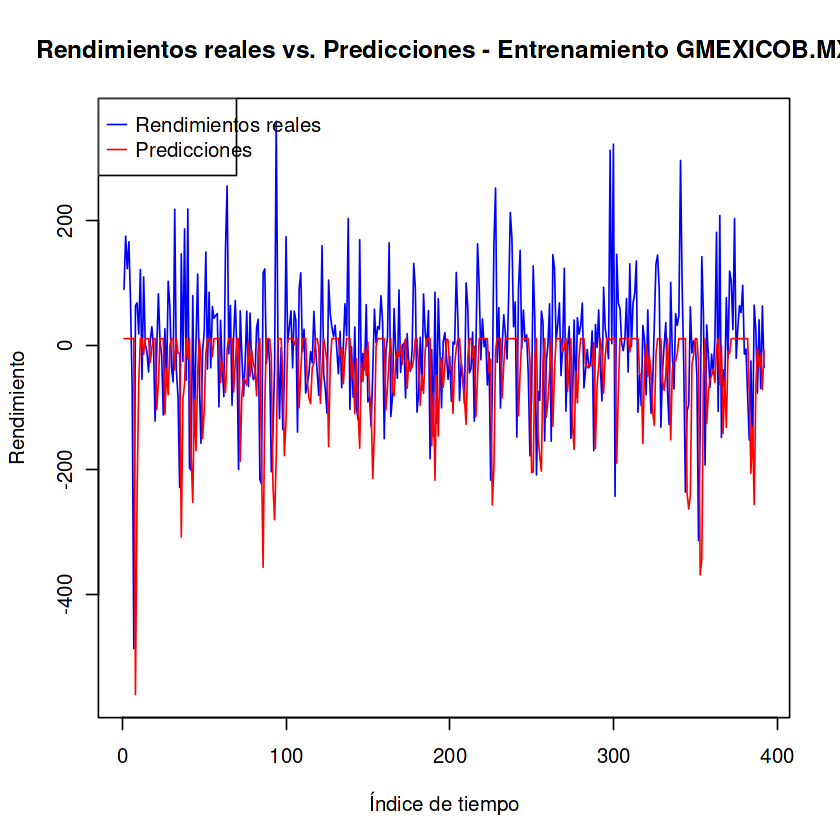

Valor real del último dato: 1.249441 
Predicción del último dato: 0.2783403 
Error absoluto del último dato: 0.9711003 
MSE del último dato: 0.9430357 


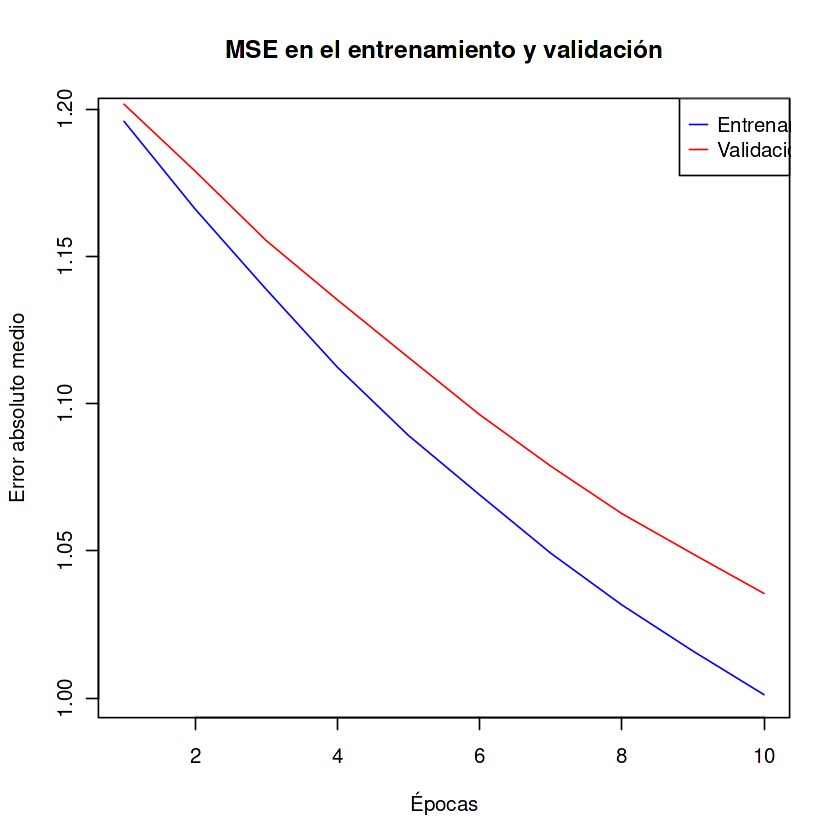

In [ ]:
# Cargar las bibliotecas necesarias
library(keras)
library(quantmod)

# Función para obtener los datos de Yahoo Finance
get_yahoo_data <- function(ticker, start_date, end_date) {
  data <- getSymbols(ticker, src = 'yahoo', from = start_date, to = end_date, auto.assign = FALSE)
  return(data)
}

# Calcular los rendimientos logarítmicos
calculate_returns <- function(data) {
  log_returns <- na.omit(diff(log(Cl(data))))  # Diferencia logarítmica de precios de cierre
  return(log_returns)
}

# Descargar los datos de Yahoo Finance
ticker <- "GMEXICOB.MX"  # Reemplazar por el ticker de tu interés
start_date <- "2023-01-01"
end_date <- "2024-12-22"
data <- get_yahoo_data(ticker, start_date, end_date)

# Calcular los rendimientos logarítmicos
returns <- calculate_returns(data)

# Calcular la ACF y obtener el lag más significativo
acf_result <- acf(returns, lag.max = 20, plot = TRUE, main = paste("ACF de los rendimientos de", ticker))
lags <- acf_result$lag[-1]  # Excluir el lag 0
acf_values <- acf_result$acf[-1]
max_abs_lag <- which.max(abs(acf_values))
lag_significant <- if (length(lags) > 0) lags[max_abs_lag] else 5  # Si no se encuentra lag, poner 5 como predeterminado

cat("El lag con mayor valor absoluto es:", lags[max_abs_lag], "con un valor de:", acf_values[max_abs_lag], "\n")
cat("El lag más significativo es:", lag_significant, "\n")

# Definir la función para generar datos laggeados
generate_lagged_data <- function(returns, lag) {
  n <- length(returns)
  data_matrix <- matrix(NA, nrow = n - lag, ncol = lag + 1)
  for (i in 1:(n - lag)) {
    data_matrix[i, ] <- returns[i:(i + lag)]
  }
  colnames(data_matrix) <- c(paste0("Lag_", 1:lag), "Target")
  return(as.data.frame(data_matrix))
}

# Generar datos laggeados
lag <- as.integer(lag_significant)
lagged_data <- generate_lagged_data(returns, lag)

# Eliminar los valores NA de los datos
lagged_data <- na.omit(lagged_data)

# Separar el último día para evaluación final
final_test <- lagged_data[nrow(lagged_data), , drop = FALSE]
lagged_data <- lagged_data[-nrow(lagged_data), ]

# Dividir los datos restantes en entrenamiento y validación
set.seed(42)
train_ratio <- 0.8
train_size <- floor(train_ratio * nrow(lagged_data))
train_data <- lagged_data[1:train_size, ]
validation_data <- lagged_data[(train_size + 1):nrow(lagged_data), ]

# Normalizar los datos de entrenamiento y validación
normalize <- function(x) {
  if (all(is.na(x))) {
    return(rep(NA, length(x)))  # Si todos son NA, devuelve NA
  }
  if (sd(x, na.rm = TRUE) == 0 || is.na(sd(x, na.rm = TRUE))) {
    return(rep(0, length(x)))  # Evitar divisiones por cero o NA
  }
  return((x - mean(x, na.rm = TRUE)) / sd(x, na.rm = TRUE))
}

train_data_normalized <- as.data.frame(lapply(train_data, normalize))
validation_data_normalized <- as.data.frame(lapply(validation_data, normalize))

# Normalizar los datos de prueba
final_test_normalized <- tryCatch({
  as.data.frame(lapply(final_test, normalize))
}, error = function(e) {
  stop("Error al normalizar final_test: ", e$message)
})

# Verificar si final_test_normalized contiene valores válidos
if (any(is.na(final_test_normalized))) {
  stop("Error: Los datos de prueba normalizados contienen valores NA o inválidos.")
}

# Definir la arquitectura del modelo de red neuronal
input_size <- lag
hidden_size <- lag - 1
output_size <- 1

# Crear el modelo de red neuronal utilizando Keras
model <- keras_model_sequential() %>%
  layer_dense(units = hidden_size, activation = "relu", input_shape = c(input_size)) %>%
  layer_dense(units = output_size)

# Compilar el modelo
model %>% compile(
  loss = "mean_squared_error",
  optimizer = optimizer_adam(lr = 0.001),
  metrics = c("mean_absolute_error")
)

# Preparar los datos de entrenamiento y validación para Keras
X_train <- as.matrix(train_data_normalized[, -ncol(train_data_normalized)])
Y_train <- as.matrix(train_data_normalized[, ncol(train_data_normalized)])
X_val <- as.matrix(validation_data_normalized[, -ncol(validation_data_normalized)])
Y_val <- as.matrix(validation_data_normalized[, ncol(validation_data_normalized)])

# Entrenar el modelo
history <- model %>% fit(
  X_train,
  Y_train,
  epochs = 10,
  batch_size = 32,
  validation_data = list(X_val, Y_val)
)

# Graficar los rendimientos reales vs. las predicciones durante el entrenamiento
Y_train_pred <- model %>% predict(X_train)
Y_val_pred <- model %>% predict(X_val)

plot(Y_train * 100, type = "l", col = "blue", ylim = c(min(c(Y_train, Y_train_pred)) * 100, max(c(Y_train, Y_train_pred)) * 100), xlab = "Índice de tiempo", ylab = "Rendimiento", main = paste("Rendimientos reales vs. Predicciones - Entrenamiento", ticker))
lines(Y_train_pred * 100, col = "red")
legend("topleft", legend = c("Rendimientos reales", "Predicciones"), col = c("blue", "red"), lty = 1)

# Graficar el MSE en el entrenamiento y la validación
plot(history$metrics$mean_absolute_error, type = "l", col = "blue", xlab = "Épocas", ylab = "Error absoluto medio", main = "MSE en el entrenamiento y validación")
lines(history$metrics$val_mean_absolute_error, col = "red")
legend("topright", legend = c("Entrenamiento", "Validación"), col = c("blue", "red"), lty = 1)

# Evaluar el modelo con el último dato (final_test) sin normalizar
X_final_test <- as.matrix(final_test_normalized[, -ncol(final_test_normalized)])
Y_final_test <- final_test_normalized[, ncol(final_test_normalized)]
Y_pred_final <- model %>% predict(X_final_test)

# Invertir la normalización de la predicción final
min_val <- min(lagged_data$Target, na.rm = TRUE)
max_val <- max(lagged_data$Target, na.rm = TRUE)
mean_val <- mean(lagged_data$Target, na.rm = TRUE)
sd_val <- sd(lagged_data$Target, na.rm = TRUE)

Y_pred_final_inverted <- (Y_pred_final * sd_val) + mean_val
Y_final_test_inverted <- returns[length(returns)]

# Calcular los errores para los datos invertidos
if (!is.na(Y_pred_final_inverted) && !is.na(Y_final_test_inverted)) {
  mse_final <- (((Y_pred_final_inverted - Y_final_test_inverted) * 100)^2)
  abs_error_final <- abs(Y_pred_final_inverted - Y_final_test_inverted) * 100
  cat("Valor real del último dato:", Y_final_test_inverted * 100, "\n")
  cat("Predicción del último dato:", Y_pred_final_inverted * 100, "\n")
  cat("Error absoluto del último dato:", abs_error_final, "\n")
  cat("MSE del último dato:", mse_final, "\n")
}